# RNN

In [30]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

import unicodedata
import string

In [31]:
# 받은 데이터 파일의 디렉도리 주소로 주기
path = 'C:/Users/jewon/AIClass/names'
def findFiles(path): return glob.glob(path)
print(findFiles(path+'/*.txt'))

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# 유니코드 문자열을 ASCII로 변환, https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn' # 성조를 유니코드에 맞게 변경
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

['C:/Users/jewon/AIClass/names\\Arabic.txt', 'C:/Users/jewon/AIClass/names\\Chinese.txt', 'C:/Users/jewon/AIClass/names\\Czech.txt', 'C:/Users/jewon/AIClass/names\\Dutch.txt', 'C:/Users/jewon/AIClass/names\\English.txt', 'C:/Users/jewon/AIClass/names\\French.txt', 'C:/Users/jewon/AIClass/names\\German.txt', 'C:/Users/jewon/AIClass/names\\Greek.txt', 'C:/Users/jewon/AIClass/names\\Irish.txt', 'C:/Users/jewon/AIClass/names\\Italian.txt', 'C:/Users/jewon/AIClass/names\\Japanese.txt', 'C:/Users/jewon/AIClass/names\\Korean.txt', 'C:/Users/jewon/AIClass/names\\Polish.txt', 'C:/Users/jewon/AIClass/names\\Portuguese.txt', 'C:/Users/jewon/AIClass/names\\Russian.txt', 'C:/Users/jewon/AIClass/names\\Scottish.txt', 'C:/Users/jewon/AIClass/names\\Spanish.txt', 'C:/Users/jewon/AIClass/names\\Vietnamese.txt']
Slusarski


In [32]:
# 각 언어의 이름 목록인 category_lines 사전 생성
category_lines = {}
all_categories = []

# 파일을 읽고 줄 단위로 분리
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles(path+'/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0] # 나라별 이름이 들어간다
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines # {나라:[이름 배열]}

n_categories = len(all_categories) # 나라 종류
print(n_categories)

18


In [33]:
all_categories

['Arabic',
 'Chinese',
 'Czech',
 'Dutch',
 'English',
 'French',
 'German',
 'Greek',
 'Irish',
 'Italian',
 'Japanese',
 'Korean',
 'Polish',
 'Portuguese',
 'Russian',
 'Scottish',
 'Spanish',
 'Vietnamese']

In [34]:
print(category_lines['Italian'][:5]) # 이탈리아 이름 예시

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [35]:
import torch

# all_letters 로 문자의 주소 찾기, 예시 "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# 검증을 위해서 한 개의 문자를 <1 x n_letters> Tensor로 변환
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# 한 줄(이름)을  <line_length x 1 x n_letters>,
# 또는 One-Hot 문자 벡터의 Array로 변경
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line): # enumerate는 인덱싱 번호와 해당 값을 튜플로 반환. 
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [36]:
print(letterToIndex('a')) # 모든 알파벳과 .,;' 합친 순서 리턴
print(letterToIndex('\'')) # a는 0부터 '는56 까지

0
56


In [37]:
print(letterToTensor('J')) # 인덱스를 텐서로 변환
print(lineToTensor('Jones').size()) # 각 문자를 one-hot encoding한 문자열 길이의 텐서로 만든다

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [38]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1) # 입력과 히든 레이어 결과를 concat한다
        hidden = self.i2h(combined) # hidden 레이어
        output = self.i2o(combined) # output 레이어
        output = self.softmax(output) # 클래스별 분류를 위한 activation function
        return output, hidden # 결과와 hidden layer 값 반환

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128 # 히든 레이터의 feature 크기를 128로 지정
rnn = RNN(n_letters, n_hidden, n_categories) # 글자 개수, 히든 레이어 크기 (128), 나라 개수 (학습 후 결과로 나올 나라의 수)

In [39]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input, hidden)

In [40]:
print(input.size()) # a의 벡터화 된
print(output.size(), next_hidden.size()) # 반환된 output과 hidden vector의 크기

torch.Size([1, 57])
torch.Size([1, 18]) torch.Size([1, 128])


In [41]:
output

tensor([[-2.9205, -2.9166, -2.8686, -2.7881, -2.7721, -2.9078, -2.9567, -2.8488,
         -3.0186, -2.8511, -3.0256, -2.8781, -2.8017, -2.9063, -2.8910, -2.9085,
         -2.8713, -2.9353]], grad_fn=<LogSoftmaxBackward0>)

In [42]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)  # 텐서의 가장 큰 값 및 주소
    category_i = top_i[0].item()   # 텐서에서 정수 값으로 변경, top_i는 [[17]] 형태
    return all_categories[category_i], category_i # 클래스와 해당하는 나라 return

print(categoryFromOutput(output))

('English', 4)


In [43]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# 랜덤으로 선택된 국가와 라인(이름), 국가 인덱스, 라인 텐서 반환
def randomTrainingExample():
    category = randomChoice(all_categories) # 랜덤 국가
    line = randomChoice(category_lines[category]) # 랜덤 이름
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Korean / line = Ri
category = Spanish / line = Vargas
category = Irish / line = Tadhg
category = Arabic / line = Isa
category = Korean / line = Chong
category = Japanese / line = Togo
category = Korean / line = Chweh
category = Japanese / line = Yanagi
category = Vietnamese / line = Quyen
category = Russian / line = Shahtin


## 네트워크 학습

## Negative Log-likelihood Loss
$ NLLLoss = -∑^{n}_{1}{y_{i}\log{\hat{y}_i}} $  
즉 CE Loss와 수식은 동일

In [44]:
'''
pytorch에서 CELoss와 차이는 softmax이다
CELoss는 실제 값을 바로 받지만 NLLLoss는 확률값을 입력으로 받는다.
즉, CELoss는 모델안에 마지막 활성화 함수가 Softmax가 아니어야 하지만
    NLLLoss를 사용하기 위해서는 모델의 마지막에 Softmax가 필요하다.
'''
criterion = nn.NLLLoss()

In [45]:
learning_rate = 0.005  # 학습률을 너무 높게 설정하면 발산할 수 있고, 너무 낮으면 학습이 되지 않을 수 있습니다.

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # 매개변수의 경사도에 학습률을 곱해서 그 매개변수의 값에 더합니다.
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [46]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# 도식화를 위한 손실 추적
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # ``iter`` 숫자, 손실, 이름, 추측 화면 출력
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # 현재 평균 손실을 전체 손실 리스트에 추가
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 3s) 2.4179 Han / Chinese ✗ (Vietnamese)
10000 10% (0m 7s) 1.5231 Ardovini / Italian ✓
15000 15% (0m 11s) 2.5639 Groves / Portuguese ✗ (English)
20000 20% (0m 15s) 0.1822 Papadelias / Greek ✓
25000 25% (0m 19s) 1.5242 Lefevre / French ✓
30000 30% (0m 23s) 1.0324 Nader / Arabic ✓
35000 35% (0m 27s) 1.9379 Andrysiak / Czech ✗ (Polish)
40000 40% (0m 31s) 1.5312 Maria / Arabic ✗ (Portuguese)
45000 45% (0m 35s) 1.8651 Belo / Spanish ✗ (Portuguese)
50000 50% (0m 39s) 6.1964 Boulos / Greek ✗ (Arabic)
55000 55% (0m 43s) 1.3906 Bello / Italian ✗ (Spanish)
60000 60% (0m 46s) 1.2060 Esteves / Portuguese ✓
65000 65% (0m 50s) 1.2504 Alfaro / Spanish ✓
70000 70% (0m 54s) 0.3591 Zabek / Polish ✓
75000 75% (0m 58s) 0.1907 Youj / Korean ✓
80000 80% (1m 1s) 0.5304 Mustafa / Arabic ✓
85000 85% (1m 5s) 1.4658 Fraser / German ✗ (Scottish)
90000 90% (1m 9s) 2.5145 Awramtchik / Czech ✗ (Russian)
95000 95% (1m 13s) 0.3832 Narvaez / Spanish ✓
100000 100% (1m 17s) 0.1595 Romeijnders / Dutch ✓


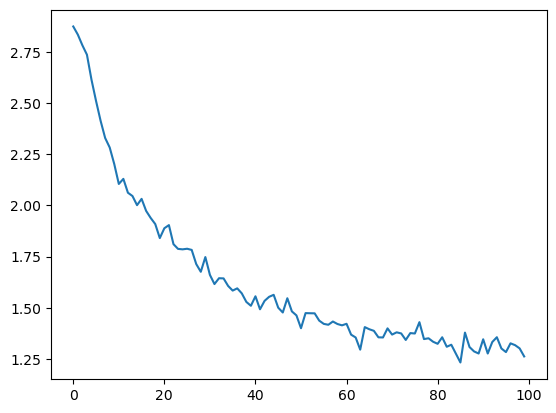

In [47]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

C:\Users\jewon\AppData\Local\Temp\ipykernel_332940\2811754854.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\jewon\AppData\Local\Temp\ipykernel_332940\2811754854.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


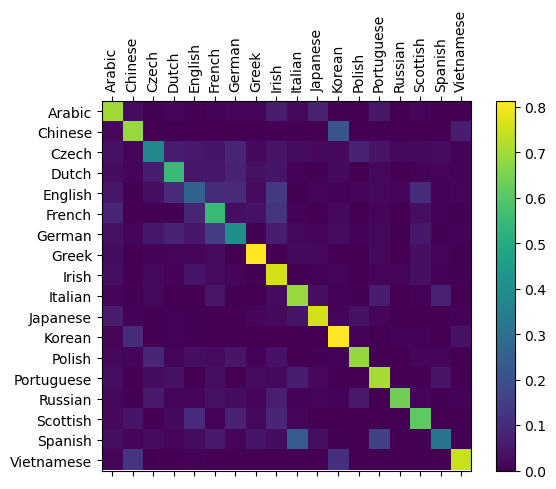

In [48]:
# 혼란 행렬에서 정확한 추측을 추적
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# 주어진 라인의 출력 반환
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# 예시 중 어떤 것이 정확히 예측되었는지 기록
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# 모든 행을 합계로 나누어 정규화
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# 도식 설정
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# 축 설정
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# 모든 tick에서 레이블 지정
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [57]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])


predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('kimjewon')


> Dovesky
(-0.74) Russian
(-0.98) Czech
(-2.71) English

> Jackson
(-0.14) Scottish
(-2.74) English
(-3.96) Greek

> Satoshi
(-1.03) Italian
(-1.59) Japanese
(-2.09) Polish

> kimjewon
(-0.69) Korean
(-1.95) English
(-2.19) Russian


# LSTM

In [21]:
import torch.nn.functional as F
from torch.autograd import Variable

In [22]:
class LSTMCell(nn.Module) :
  def __init__(self, input_size, hidden_size, bias=True) :
    super(LSTMCell, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias
    self.x2h = nn.Linear(input_size, 4*hidden_size, bias=bias)
    self.h2h = nn.Linear(hidden_size, 4*hidden_size, bias=bias)
    self.reset_parameters()

  def reset_parameters(self) :
    std = 1.0 / math.sqrt(self.hidden_size)
    for w in self.parameters() :
        w.data.uniform_(-std, std)

  def forward(self, x, hidden) :
    hx, cx = hidden
    x = x.view(-1, x.size(1))

    gates = self.x2h(x) + self.h2h(hx)
    # gates = gates.squeeze()

    ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)

    ingate = F.sigmoid(ingate) # 입력 게이트에 시그모이드 적용
    forgetgate = F.sigmoid(forgetgate) # 망각 게이트에 시그모이드 적용
    cellgate = F.tanh(cellgate) # 셀 게이트에 탄젠트 적용
    outgate = F.sigmoid(outgate) # 출력 게이트에 시그모이드 적용

    cy = torch.mul(cx, forgetgate) + torch.mul(ingate, cellgate)
    hy = torch.mul(outgate, F.tanh(cy))

    return (hy, cy)

In [23]:
class LSTMModel(nn.Module) :
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True) :
    super(LSTMModel, self).__init__()
    self.hidden_dim = hidden_dim

    self.layer_dim = layer_dim
    self.lstm = LSTMCell(input_dim, hidden_dim, layer_dim)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x) :
    h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
    c0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

    outs = []
    cn =  c0[0,:,:]
    hn = h0[0,:,:]

    for seq in range(x.size(1)) :
        hn, cn = self.lstm(x, (hn, cn))
        outs.append(hn)

    out = outs[-1]#.squeeze()
    out = self.fc(out)
    return out

In [24]:
lstm_input_dim=57
lstm_hidden_dim=128
lstm_layer_dim=1
lstm_output_dim=18

lstm_model =  LSTMModel(lstm_input_dim, lstm_hidden_dim, lstm_layer_dim, lstm_output_dim)

In [25]:
learning_rate = 0.01
def lstm_train(category_tensor, line_tensor):
    lstm_model.zero_grad()

    for i in range(line_tensor.size()[0]):
        output = lstm_model(line_tensor[i])

    loss = criterion(output, category_tensor)
    loss.backward()

    # 매개변수의 경사도에 학습률을 곱해서 그 매개변수의 값에 더합니다.
    for p in lstm_model.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [26]:
import time
import math

n_iters = 10000
print_every = 500
plot_every = 1000

# 도식화를 위한 손실 추적
lstm_current_loss = 0
lstm_all_losses = []

start = time.time()
current_loss = 0

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = lstm_train(category_tensor, line_tensor)
    current_loss += loss

    # ``iter`` 숫자, 손실, 이름, 추측 화면 출력
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # 현재 평균 손실을 전체 손실 리스트에 추가
    if iter % plot_every == 0:
        lstm_all_losses.append(current_loss / plot_every)
        current_loss = 0

500 5% (0m 28s) -0.4649 Santos / Italian ✗ (Spanish)
1000 10% (0m 58s) -5.5935 Hoang / German ✗ (Vietnamese)
1500 15% (1m 27s) -37.7108 Shalhoub / Scottish ✗ (Arabic)
2000 20% (1m 55s) -77.7049 Howell / Spanish ✗ (English)
2500 25% (2m 22s) -103.8567 Cabral / Polish ✗ (Portuguese)
3000 30% (2m 51s) -139.8087 Murphy / Spanish ✗ (Scottish)
3500 35% (3m 21s) -185.9386 Hishikawa / Czech ✗ (Japanese)
4000 40% (3m 48s) -211.8490 Labelle / Czech ✗ (French)
4500 45% (4m 16s) -232.2871 William / Czech ✗ (Irish)
5000 50% (4m 44s) -286.0527 Andres / Czech ✗ (German)
5500 55% (5m 14s) -336.9554 Choe / Czech ✗ (Korean)
6000 60% (5m 41s) -377.1541 Taylor / Czech ✗ (Scottish)
6500 65% (6m 7s) -378.0542 Ivor / Czech ✗ (Irish)
7000 70% (6m 33s) -423.7712 Torres / Spanish ✗ (Portuguese)
7500 75% (6m 59s) -466.6522 Falk / Spanish ✗ (German)
8000 80% (7m 26s) -455.5911 Abba / Spanish ✗ (Italian)
8500 85% (7m 53s) -536.2216 Maksimychev / Spanish ✗ (Russian)
9000 90% (8m 20s) -571.1599 Petimezas / Polish ✗ 

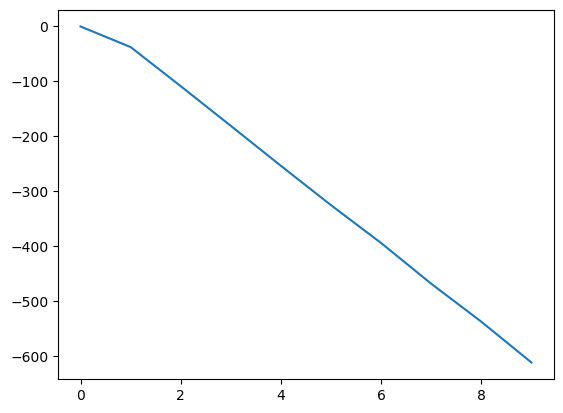

In [27]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(lstm_all_losses)

C:\Users\jewon\AppData\Local\Temp\ipykernel_332940\3136069801.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\jewon\AppData\Local\Temp\ipykernel_332940\3136069801.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


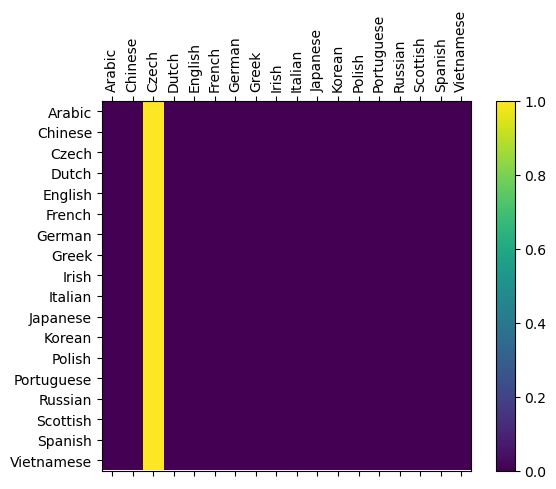

In [28]:
# 혼란 행렬에서 정확한 추측을 추적
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 1000

# 주어진 라인의 출력 반환
def evaluate(line_tensor):

    for i in range(line_tensor.size()[0]):
        output = lstm_model(line_tensor[i])

    return output

# 예시 중 어떤 것이 정확히 예측되었는지 기록
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# 모든 행을 합계로 나누어 정규화
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# 도식 설정
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# 축 설정
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# 모든 tick에서 레이블 지정
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()